# UIDAI Hackathon PS-1: Feature Engineering
## Predictive Analysis of Aadhaar Update Demand

This notebook performs comprehensive feature engineering on cleaned Aadhaar datasets to create predictive features for update demand forecasting.

### Input Datasets:
- **Cleaned Enrolment Data**: New Aadhaar enrollments by age group
- **Cleaned Demographic Data**: Demographic update requests
- **Cleaned Biometric Data**: Biometric update requests

### Feature Engineering Tasks:
1. **Temporal Features**: Date-based features (month, quarter, day of week, etc.)
2. **Demographic Features**: Age group ratios and distributions
3. **Update Features**: Update rates and ratios
4. **Geographic Features**: State/district encoding and regional grouping
5. **Lag Features**: Historical patterns (7, 14, 30 days)
6. **Aggregated Features**: State/district level statistics
7. **Target Variables**: Future update demand (7, 15, 30 days ahead)

### Output:
- **Feature Matrix**: `outputs/results/feature_matrix.csv`
- Feature correlation analysis
- Feature importance preliminary assessment

## 1. Import Required Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn for encoding and preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Current date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✓ Libraries imported successfully!
Pandas version: 2.3.3
NumPy version: 2.4.1
Current date: 2026-01-18 12:17:25


## 2. Load Cleaned Datasets

Load the cleaned datasets from the previous data cleaning step.

In [3]:
# Define paths
BASE_PATH = Path('/home/prince/Desktop/UIDAI Hackathon')
INPUT_PATH = BASE_PATH / 'outputs' / 'results'
OUTPUT_PATH = BASE_PATH / 'outputs' / 'results'

print("=" * 80)
print("LOADING CLEANED DATASETS")
print("=" * 80)

# Load cleaned datasets
df_enrolment = pd.read_csv(INPUT_PATH / 'cleaned_enrolment.csv')
df_demographic = pd.read_csv(INPUT_PATH / 'cleaned_demographic.csv')
df_biometric = pd.read_csv(INPUT_PATH / 'cleaned_biometric.csv')

print(f"\n✓ Enrolment Data: {df_enrolment.shape[0]:,} rows × {df_enrolment.shape[1]} columns")
print(f"✓ Demographic Data: {df_demographic.shape[0]:,} rows × {df_demographic.shape[1]} columns")
print(f"✓ Biometric Data: {df_biometric.shape[0]:,} rows × {df_biometric.shape[1]} columns")

# Convert date columns to datetime
df_enrolment['date'] = pd.to_datetime(df_enrolment['date'])
df_demographic['date'] = pd.to_datetime(df_demographic['date'])
df_biometric['date'] = pd.to_datetime(df_biometric['date'])

print("\n✓ Date columns converted to datetime")
print("\nDate ranges:")
print(f"  Enrolment: {df_enrolment['date'].min()} to {df_enrolment['date'].max()}")
print(f"  Demographic: {df_demographic['date'].min()} to {df_demographic['date'].max()}")
print(f"  Biometric: {df_biometric['date'].min()} to {df_biometric['date'].max()}")

# Display sample data
print("\n" + "=" * 80)
print("SAMPLE DATA")
print("=" * 80)
print("\nEnrolment Data:")
display(df_enrolment.head())
print("\nDemographic Data:")
display(df_demographic.head())
print("\nBiometric Data:")
display(df_biometric.head())

LOADING CLEANED DATASETS

✓ Enrolment Data: 966,443 rows × 7 columns
✓ Demographic Data: 1,584,531 rows × 6 columns
✓ Biometric Data: 1,744,259 rows × 6 columns

✓ Date columns converted to datetime

Date ranges:
  Enrolment: 2025-03-02 00:00:00 to 2025-12-29 00:00:00
  Demographic: 2025-04-01 00:00:00 to 2025-12-29 00:00:00
  Biometric: 2025-04-01 00:00:00 to 2025-12-29 00:00:00

SAMPLE DATA

Enrolment Data:


,date,state,district,pincode,age_0_5,age_5_17,age_18_greater
0,2025-03-02,Meghalaya,East Khasi Hills,793121,6,2.5000,0
1,2025-03-09,Karnataka,Bengaluru Urban,560043,6,2.5000,0
2,2025-03-09,Uttar Pradesh,Kanpur Nagar,208001,6,2.5000,0
3,2025-03-09,Uttar Pradesh,Aligarh,202133,6,2.5000,0
4,2025-03-09,Karnataka,Bengaluru Urban,560016,6,2.5000,0



Demographic Data:


,date,state,district,pincode,demo_age_5_17,demo_age_17_
0,2025-04-01,Haryana,Jind,126112,5,34.5000
1,2025-04-01,Rajasthan,Kota,324001,5,34.5000
2,2025-04-01,Andhra Pradesh,Visakhapatnam,530027,5,34.5000
3,2025-04-01,Rajasthan,Jaipur,302015,5,34.5000
4,2025-04-01,Tamil Nadu,Kancheepuram,631501,5,34.5000



Biometric Data:


,date,state,district,pincode,bio_age_5_17,bio_age_17_
0,2025-04-01,Gujarat,Valsad,396051,26,23.5000
1,2025-04-01,Maharashtra,Palghar,401404,26,23.5000
2,2025-04-01,Rajasthan,Jaipur,302019,26,23.5000
3,2025-04-01,Madhya Pradesh,Betul,460440,26,23.5000
4,2025-04-01,Himachal Pradesh,Kangra,176021,26,23.5000


## 3. Create Temporal Features

Extract comprehensive time-based features from the date column.

In [4]:
def create_temporal_features(df):
    """Create comprehensive temporal features from date column"""
    print(f"Creating temporal features...")
    
    # Basic date components
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek  # Monday=0, Sunday=6
    df['week_of_year'] = df['date'].dt.isocalendar().week
    df['quarter'] = df['date'].dt.quarter
    
    # Cyclical features (useful for models)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    
    # Boolean features
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)  # Saturday=5, Sunday=6
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
    df['is_quarter_start'] = df['date'].dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df['date'].dt.is_quarter_end.astype(int)
    
    # Days since start (temporal trend)
    min_date = df['date'].min()
    df['days_since_start'] = (df['date'] - min_date).dt.days
    
    # Month and quarter names (for analysis)
    df['month_name'] = df['date'].dt.month_name()
    df['quarter_name'] = 'Q' + df['quarter'].astype(str)
    
    print(f"  ✓ Created {16} temporal features")
    return df

print("=" * 80)
print("TASK 1: TEMPORAL FEATURES")
print("=" * 80)

df_enrolment = create_temporal_features(df_enrolment)
df_demographic = create_temporal_features(df_demographic)
df_biometric = create_temporal_features(df_biometric)

print("\n✓ Temporal features created for all datasets!")

# Display temporal features
print("\nTemporal features sample (Enrolment):")
temporal_cols = ['date', 'year', 'month', 'day', 'day_of_week', 'week_of_year', 
                 'quarter', 'is_weekend', 'is_month_start', 'is_month_end', 'days_since_start']
display(df_enrolment[temporal_cols].head(10))

TASK 1: TEMPORAL FEATURES
Creating temporal features...
  ✓ Created 16 temporal features
Creating temporal features...
  ✓ Created 16 temporal features
Creating temporal features...
  ✓ Created 16 temporal features

✓ Temporal features created for all datasets!

Temporal features sample (Enrolment):


,date,year,month,day,day_of_week,week_of_year,quarter,is_weekend,is_month_start,is_month_end,days_since_start
0,2025-03-02,2025,3,2,6,9,1,1,0,0,0
1,2025-03-09,2025,3,9,6,10,1,1,0,0,7
2,2025-03-09,2025,3,9,6,10,1,1,0,0,7
3,2025-03-09,2025,3,9,6,10,1,1,0,0,7
4,2025-03-09,2025,3,9,6,10,1,1,0,0,7
5,2025-03-09,2025,3,9,6,10,1,1,0,0,7
6,2025-03-09,2025,3,9,6,10,1,1,0,0,7
7,2025-03-09,2025,3,9,6,10,1,1,0,0,7
8,2025-03-09,2025,3,9,6,10,1,1,0,0,7
9,2025-03-09,2025,3,9,6,10,1,1,0,0,7


## 4. Create Demographic Features

Calculate age group ratios and distributions from enrolment data.

In [5]:
def create_demographic_features(df):
    """Create demographic features from age group columns"""
    print(f"Creating demographic features...")
    
    # Identify age group columns
    age_cols = [col for col in df.columns if 'age' in col.lower() and col not in ['year']]
    print(f"  Found age columns: {age_cols}")
    
    # Total enrolment
    if all(col in df.columns for col in ['age_0_5', 'age_5_17', 'age_18_greater']):
        df['total_enrolment'] = df['age_0_5'] + df['age_5_17'] + df['age_18_greater']
        
        # Ratios (avoid division by zero)
        df['child_ratio'] = np.where(
            df['total_enrolment'] > 0,
            (df['age_0_5'] + df['age_5_17']) / df['total_enrolment'],
            0
        )
        
        df['adult_ratio'] = np.where(
            df['total_enrolment'] > 0,
            df['age_18_greater'] / df['total_enrolment'],
            0
        )
        
        df['youth_ratio'] = np.where(
            df['total_enrolment'] > 0,
            df['age_5_17'] / df['total_enrolment'],
            0
        )
        
        df['infant_ratio'] = np.where(
            df['total_enrolment'] > 0,
            df['age_0_5'] / df['total_enrolment'],
            0
        )
        
        print(f"  ✓ Created enrolment ratios (child, adult, youth, infant)")
    
    # Diversity index (similar to Gini coefficient for age distribution)
    if 'total_enrolment' in df.columns:
        df['age_diversity_index'] = 1 - (
            (df['age_0_5'] / (df['total_enrolment'] + 1)) ** 2 +
            (df['age_5_17'] / (df['total_enrolment'] + 1)) ** 2 +
            (df['age_18_greater'] / (df['total_enrolment'] + 1)) ** 2
        )
        print(f"  ✓ Created age diversity index")
    
    print(f"  ✓ Created demographic features")
    return df

print("=" * 80)
print("TASK 2: DEMOGRAPHIC FEATURES")
print("=" * 80)

df_enrolment = create_demographic_features(df_enrolment)

print("\n✓ Demographic features created!")

# Display demographic features
print("\nDemographic features sample:")
demo_cols = ['date', 'state', 'district', 'total_enrolment', 'child_ratio', 
             'adult_ratio', 'youth_ratio', 'infant_ratio', 'age_diversity_index']
display(df_enrolment[[col for col in demo_cols if col in df_enrolment.columns]].head(10))

# Statistics
print("\nDemographic feature statistics:")
stats_cols = ['total_enrolment', 'child_ratio', 'adult_ratio', 'youth_ratio', 'age_diversity_index']
display(df_enrolment[[col for col in stats_cols if col in df_enrolment.columns]].describe())

TASK 2: DEMOGRAPHIC FEATURES
Creating demographic features...
  Found age columns: ['age_0_5', 'age_5_17', 'age_18_greater']
  ✓ Created enrolment ratios (child, adult, youth, infant)
  ✓ Created age diversity index
  ✓ Created demographic features

✓ Demographic features created!

Demographic features sample:


,date,state,district,total_enrolment,child_ratio,adult_ratio,youth_ratio,infant_ratio,age_diversity_index
0,2025-03-02,Meghalaya,East Khasi Hills,8.5000,1.0000,0.0000,0.2941,0.7059,0.5319
1,2025-03-09,Karnataka,Bengaluru Urban,8.5000,1.0000,0.0000,0.2941,0.7059,0.5319
2,2025-03-09,Uttar Pradesh,Kanpur Nagar,8.5000,1.0000,0.0000,0.2941,0.7059,0.5319
3,2025-03-09,Uttar Pradesh,Aligarh,8.5000,1.0000,0.0000,0.2941,0.7059,0.5319
4,2025-03-09,Karnataka,Bengaluru Urban,8.5000,1.0000,0.0000,0.2941,0.7059,0.5319
5,2025-03-09,Bihar,Sitamarhi,8.5000,1.0000,0.0000,0.2941,0.7059,0.5319
6,2025-03-09,Bihar,Sitamarhi,8.5000,1.0000,0.0000,0.2941,0.7059,0.5319
7,2025-03-09,Uttar Pradesh,Bahraich,8.5000,1.0000,0.0000,0.2941,0.7059,0.5319
8,2025-03-09,Uttar Pradesh,Firozabad,8.5000,1.0000,0.0000,0.2941,0.7059,0.5319
9,2025-03-09,Bihar,Purbi Champaran,8.5000,1.0000,0.0000,0.2941,0.7059,0.5319



Demographic feature statistics:


,total_enrolment,child_ratio,adult_ratio,youth_ratio,age_diversity_index
count,966443.0000,966443.0000,966443.0000,966443.0000,966443.0000
mean,2.9790,0.9924,0.0000,0.2336,0.6228
std,2.3145,0.0868,0.0000,0.3282,0.1472
min,0.0000,0.0000,0.0000,0.0000,0.2653
25%,1.0000,1.0000,0.0000,0.0000,0.5319
50%,2.0000,1.0000,0.0000,0.0000,0.6612
75%,4.0000,1.0000,0.0000,0.3846,0.7500
max,8.5000,1.0000,0.0000,1.0000,1.0000


## 5. Create Update Features

Calculate update rates, ratios, and patterns from demographic and biometric data.

In [6]:
def create_update_features(df_demo, df_bio):
    """Create update-related features"""
    print(f"Creating update features...")
    
    # Total demographic updates
    demo_age_cols = [col for col in df_demo.columns if 'age' in col.lower()]
    if len(demo_age_cols) >= 2:
        df_demo['total_demographic_updates'] = df_demo[demo_age_cols].sum(axis=1)
        print(f"  ✓ Created total_demographic_updates from {len(demo_age_cols)} columns")
    
    # Total biometric updates
    bio_age_cols = [col for col in df_bio.columns if 'age' in col.lower()]
    if len(bio_age_cols) >= 2:
        df_bio['total_biometric_updates'] = df_bio[bio_age_cols].sum(axis=1)
        print(f"  ✓ Created total_biometric_updates from {len(bio_age_cols)} columns")
    
    return df_demo, df_bio

print("=" * 80)
print("TASK 3: UPDATE FEATURES")
print("=" * 80)

df_demographic, df_biometric = create_update_features(df_demographic, df_biometric)

print("\n✓ Update features created!")

# Display update features
print("\nDemographic updates sample:")
demo_update_cols = ['date', 'state', 'district', 'total_demographic_updates']
display(df_demographic[[col for col in demo_update_cols if col in df_demographic.columns]].head(10))

print("\nBiometric updates sample:")
bio_update_cols = ['date', 'state', 'district', 'total_biometric_updates']
display(df_biometric[[col for col in bio_update_cols if col in df_biometric.columns]].head(10))

# Statistics
print("\nUpdate statistics:")
if 'total_demographic_updates' in df_demographic.columns:
    print(f"Demographic updates - Mean: {df_demographic['total_demographic_updates'].mean():.2f}, "
          f"Std: {df_demographic['total_demographic_updates'].std():.2f}")
if 'total_biometric_updates' in df_biometric.columns:
    print(f"Biometric updates - Mean: {df_biometric['total_biometric_updates'].mean():.2f}, "
          f"Std: {df_biometric['total_biometric_updates'].std():.2f}")

TASK 3: UPDATE FEATURES
Creating update features...
  ✓ Created total_demographic_updates from 2 columns
  ✓ Created total_biometric_updates from 2 columns

✓ Update features created!

Demographic updates sample:


,date,state,district,total_demographic_updates
0,2025-04-01,Haryana,Jind,39.5000
1,2025-04-01,Rajasthan,Kota,39.5000
2,2025-04-01,Andhra Pradesh,Visakhapatnam,39.5000
3,2025-04-01,Rajasthan,Jaipur,39.5000
4,2025-04-01,Tamil Nadu,Kancheepuram,39.5000
5,2025-04-01,Telangana,K.V. Rangareddy,39.5000
6,2025-04-01,Uttarakhand,Udham Singh Nagar,39.5000
7,2025-04-01,Delhi,North West Delhi,39.5000
8,2025-04-01,Haryana,Sonipat,39.5000
9,2025-04-01,Karnataka,Ballari,39.5000



Biometric updates sample:


,date,state,district,total_biometric_updates
0,2025-04-01,Gujarat,Valsad,49.5000
1,2025-04-01,Maharashtra,Palghar,49.5000
2,2025-04-01,Rajasthan,Jaipur,49.5000
3,2025-04-01,Madhya Pradesh,Betul,49.5000
4,2025-04-01,Himachal Pradesh,Kangra,49.5000
5,2025-04-01,Pondicherry,Pondicherry,49.5000
6,2025-04-01,Orissa,Khordha,35.5000
7,2025-04-01,Karnataka,Kolar,49.5000
8,2025-04-01,Jharkhand,Gumla,49.5000
9,2025-04-01,Uttarakhand,Pithoragarh,49.5000



Update statistics:
Demographic updates - Mean: 11.46, Std: 11.89
Biometric updates - Mean: 14.22, Std: 15.12


## 6. Merge Datasets

Merge enrolment, demographic, and biometric datasets on (date, state, district, pincode).

In [7]:
print("=" * 80)
print("MERGING DATASETS")
print("=" * 80)

# Define merge keys
merge_keys = ['date', 'state', 'district', 'pincode']

print(f"\nMerge keys: {merge_keys}")
print(f"\nBefore merge:")
print(f"  Enrolment: {df_enrolment.shape}")
print(f"  Demographic: {df_demographic.shape}")
print(f"  Biometric: {df_biometric.shape}")

# Step 1: Merge enrolment with demographic
print("\nStep 1: Merging Enrolment + Demographic...")
df_merged = pd.merge(
    df_enrolment,
    df_demographic,
    on=merge_keys,
    how='outer',
    suffixes=('_enrol', '_demo')
)
print(f"  Result: {df_merged.shape}")

# Step 2: Merge with biometric
print("\nStep 2: Merging with Biometric...")
df_merged = pd.merge(
    df_merged,
    df_biometric,
    on=merge_keys,
    how='outer',
    suffixes=('', '_bio')
)
print(f"  Result: {df_merged.shape}")

# Handle duplicate columns from temporal features
temporal_base_cols = ['year', 'month', 'day', 'day_of_week', 'week_of_year', 'quarter',
                      'is_weekend', 'is_month_start', 'is_month_end', 'is_quarter_start',
                      'is_quarter_end', 'days_since_start', 'month_sin', 'month_cos',
                      'day_of_week_sin', 'day_of_week_cos', 'month_name', 'quarter_name']

# Drop duplicate temporal columns (keep from enrolment)
for col in temporal_base_cols:
    demo_col = col + '_demo'
    bio_col = col + '_bio'
    if demo_col in df_merged.columns:
        df_merged.drop(columns=[demo_col], inplace=True)
    if bio_col in df_merged.columns:
        df_merged.drop(columns=[bio_col], inplace=True)

print(f"\n✓ Duplicate temporal columns removed")
print(f"Final merged shape: {df_merged.shape}")

# Fill missing values with 0 for update counts
update_cols = [col for col in df_merged.columns if 'update' in col.lower() or 'age' in col.lower()]
df_merged[update_cols] = df_merged[update_cols].fillna(0)

print(f"\n✓ Missing values filled for update columns")

# Display merged data
print("\nMerged data sample:")
display(df_merged.head())

# Check for missing values
print("\nMissing values in merged dataset:")
missing = df_merged.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
if len(missing) > 0:
    display(missing)
else:
    print("  ✓ No missing values!")

MERGING DATASETS

Merge keys: ['date', 'state', 'district', 'pincode']

Before merge:
  Enrolment: (966443, 31)
  Demographic: (1584531, 25)
  Biometric: (1744259, 25)

Step 1: Merging Enrolment + Demographic...
  Result: (1899775, 52)

Step 2: Merging with Biometric...
  Result: (2294731, 73)

✓ Duplicate temporal columns removed
Final merged shape: (2294731, 55)

✓ Missing values filled for update columns

Merged data sample:


,date,state,district,pincode,age_0_5,age_5_17,age_18_greater,year_enrol,month_enrol,day_enrol,day_of_week_enrol,week_of_year_enrol,quarter_enrol,month_sin_enrol,month_cos_enrol,day_of_week_sin_enrol,day_of_week_cos_enrol,is_weekend_enrol,is_month_start_enrol,is_month_end_enrol,is_quarter_start_enrol,is_quarter_end_enrol,days_since_start_enrol,month_name_enrol,quarter_name_enrol,total_enrolment,child_ratio,adult_ratio,youth_ratio,infant_ratio,age_diversity_index,demo_age_5_17,demo_age_17_,total_demographic_updates,bio_age_5_17,bio_age_17_,year,month,day,day_of_week,week_of_year,quarter,month_sin,month_cos,day_of_week_sin,day_of_week_cos,is_weekend,is_month_start,is_month_end,is_quarter_start,is_quarter_end,days_since_start,month_name,quarter_name,total_biometric_updates
0,2025-03-02,Meghalaya,East Khasi Hills,793121,6.0000,2.5000,0.0000,2025.0000,3.0000,2.0000,6.0000,9,1.0000,1.0000,0.0000,-0.7818,0.6235,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,March,Q1,8.5000,1.0000,0.0000,0.2941,0.7059,0.5319,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000
1,2025-03-09,Bihar,Bhagalpur,812005,6.0000,2.5000,0.0000,2025.0000,3.0000,9.0000,6.0000,10,1.0000,1.0000,0.0000,-0.7818,0.6235,1.0000,0.0000,0.0000,0.0000,0.0000,7.0000,March,Q1,8.5000,1.0000,0.0000,0.2941,0.7059,0.5319,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000
2,2025-03-09,Bihar,Madhubani,847108,6.0000,2.5000,0.0000,2025.0000,3.0000,9.0000,6.0000,10,1.0000,1.0000,0.0000,-0.7818,0.6235,1.0000,0.0000,0.0000,0.0000,0.0000,7.0000,March,Q1,8.5000,1.0000,0.0000,0.2941,0.7059,0.5319,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000
3,2025-03-09,Bihar,Purbi Champaran,845304,6.0000,2.5000,0.0000,2025.0000,3.0000,9.0000,6.0000,10,1.0000,1.0000,0.0000,-0.7818,0.6235,1.0000,0.0000,0.0000,0.0000,0.0000,7.0000,March,Q1,8.5000,1.0000,0.0000,0.2941,0.7059,0.5319,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000
4,2025-03-09,Bihar,Purbi Champaran,845418,6.0000,2.5000,0.0000,2025.0000,3.0000,9.0000,6.0000,10,1.0000,1.0000,0.0000,-0.7818,0.6235,1.0000,0.0000,0.0000,0.0000,0.0000,7.0000,March,Q1,8.5000,1.0000,0.0000,0.2941,0.7059,0.5319,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000



Missing values in merged dataset:


year_enrol                1324464
month_enrol               1324464
day_enrol                 1324464
day_of_week_enrol         1324464
week_of_year_enrol        1324464
quarter_enrol             1324464
month_sin_enrol           1324464
month_cos_enrol           1324464
day_of_week_sin_enrol     1324464
day_of_week_cos_enrol     1324464
is_weekend_enrol          1324464
is_month_start_enrol      1324464
is_month_end_enrol        1324464
is_quarter_start_enrol    1324464
is_quarter_end_enrol      1324464
days_since_start_enrol    1324464
month_name_enrol          1324464
quarter_name_enrol        1324464
total_enrolment           1324464
child_ratio               1324464
adult_ratio               1324464
youth_ratio               1324464
infant_ratio              1324464
year                       546471
month                      546471
day                        546471
day_of_week                546471
week_of_year               546471
quarter                    546471
month_sin     

## 7. Create Geographic Features

Encode geographic information and create regional groupings.

In [8]:
print("=" * 80)
print("TASK 4: GEOGRAPHIC FEATURES")
print("=" * 80)

# Label encoding for state and district
print("\nCreating label encodings...")
le_state = LabelEncoder()
le_district = LabelEncoder()

df_merged['state_encoded'] = le_state.fit_transform(df_merged['state'].astype(str))
df_merged['district_encoded'] = le_district.fit_transform(df_merged['district'].astype(str))

print(f"  ✓ State encoded: {df_merged['state_encoded'].nunique()} unique states")
print(f"  ✓ District encoded: {df_merged['district_encoded'].nunique()} unique districts")

# Pincode-based regional grouping (first digit represents zone in India)
df_merged['pincode_zone'] = (df_merged['pincode'] // 100000).astype(int)
print(f"  ✓ Pincode zones created: {df_merged['pincode_zone'].nunique()} zones")

# Calculate location-based features
print("\nCalculating location-based statistics...")

# Count of unique pincodes per district (proxy for area coverage)
pincode_per_district = df_merged.groupby('district')['pincode'].nunique().to_dict()
df_merged['pincodes_in_district'] = df_merged['district'].map(pincode_per_district)

# Count of records per location (proxy for activity level)
location_counts = df_merged.groupby(['state', 'district']).size().to_dict()
df_merged['location_activity_level'] = df_merged.apply(
    lambda x: location_counts.get((x['state'], x['district']), 0), axis=1
)

print(f"  ✓ Created pincodes_in_district feature")
print(f"  ✓ Created location_activity_level feature")

# Population density proxy (total enrolment / pincodes in district)
if 'total_enrolment' in df_merged.columns:
    df_merged['population_density_proxy'] = np.where(
        df_merged['pincodes_in_district'] > 0,
        df_merged['total_enrolment'] / df_merged['pincodes_in_district'],
        0
    )
    print(f"  ✓ Created population_density_proxy feature")

print("\n✓ Geographic features created!")

# Display geographic features
print("\nGeographic features sample:")
geo_cols = ['state', 'district', 'pincode', 'state_encoded', 'district_encoded', 
            'pincode_zone', 'pincodes_in_district', 'location_activity_level']
display(df_merged[[col for col in geo_cols if col in df_merged.columns]].head(10))

# Geographic statistics
print("\nGeographic distribution:")
print(f"  Unique states: {df_merged['state'].nunique()}")
print(f"  Unique districts: {df_merged['district'].nunique()}")
print(f"  Unique pincodes: {df_merged['pincode'].nunique()}")
print(f"  Unique pincode zones: {df_merged['pincode_zone'].nunique()}")

TASK 4: GEOGRAPHIC FEATURES

Creating label encodings...
  ✓ State encoded: 60 unique states
  ✓ District encoded: 1002 unique districts
  ✓ Pincode zones created: 8 zones

Calculating location-based statistics...
  ✓ Created pincodes_in_district feature
  ✓ Created location_activity_level feature
  ✓ Created population_density_proxy feature

✓ Geographic features created!

Geographic features sample:


,state,district,pincode,state_encoded,district_encoded,pincode_zone,pincodes_in_district,location_activity_level
0,Meghalaya,East Khasi Hills,793121,34,272,7,33,2361
1,Bihar,Bhagalpur,812005,7,126,8,37,3087
2,Bihar,Madhubani,847108,7,544,8,46,4197
3,Bihar,Purbi Champaran,845304,7,735,8,12,24
4,Bihar,Purbi Champaran,845418,7,735,8,12,24
5,Bihar,Sitamarhi,843317,7,849,8,26,2439
6,Bihar,Sitamarhi,843324,7,849,8,26,2439
7,Bihar,Sitamarhi,843330,7,849,8,26,2439
8,Bihar,Sitamarhi,843331,7,849,8,26,2439
9,Delhi,West Delhi,110018,17,979,1,11,1055



Geographic distribution:
  Unique states: 60
  Unique districts: 1002
  Unique pincodes: 19815
  Unique pincode zones: 8


## 8. Create Update Rate Features

Calculate update rates per region by combining enrolment and update data.

In [9]:
print("=" * 80)
print("CREATING UPDATE RATE FEATURES")
print("=" * 80)

# Calculate update rates
if 'total_enrolment' in df_merged.columns:
    if 'total_demographic_updates' in df_merged.columns:
        df_merged['demographic_update_rate'] = np.where(
            df_merged['total_enrolment'] > 0,
            df_merged['total_demographic_updates'] / df_merged['total_enrolment'],
            0
        )
        print("  ✓ Created demographic_update_rate")
    
    if 'total_biometric_updates' in df_merged.columns:
        df_merged['biometric_update_rate'] = np.where(
            df_merged['total_enrolment'] > 0,
            df_merged['total_biometric_updates'] / df_merged['total_enrolment'],
            0
        )
        print("  ✓ Created biometric_update_rate")
    
    # Total update rate
    if 'total_demographic_updates' in df_merged.columns and 'total_biometric_updates' in df_merged.columns:
        df_merged['total_updates'] = df_merged['total_demographic_updates'] + df_merged['total_biometric_updates']
        df_merged['total_update_rate'] = np.where(
            df_merged['total_enrolment'] > 0,
            df_merged['total_updates'] / df_merged['total_enrolment'],
            0
        )
        print("  ✓ Created total_update_rate")

# Demographic to biometric update ratio
if 'total_demographic_updates' in df_merged.columns and 'total_biometric_updates' in df_merged.columns:
    df_merged['demographic_biometric_ratio'] = np.where(
        df_merged['total_biometric_updates'] > 0,
        df_merged['total_demographic_updates'] / df_merged['total_biometric_updates'],
        0
    )
    print("  ✓ Created demographic_biometric_ratio")

print("\n✓ Update rate features created!")

# Display update rate features
print("\nUpdate rate features sample:")
rate_cols = ['date', 'state', 'district', 'demographic_update_rate', 
             'biometric_update_rate', 'total_update_rate', 'demographic_biometric_ratio']
display(df_merged[[col for col in rate_cols if col in df_merged.columns]].head(10))

# Statistics
print("\nUpdate rate statistics:")
rate_stat_cols = ['demographic_update_rate', 'biometric_update_rate', 'total_update_rate']
for col in rate_stat_cols:
    if col in df_merged.columns:
        print(f"  {col}: Mean={df_merged[col].mean():.4f}, Std={df_merged[col].std():.4f}")

CREATING UPDATE RATE FEATURES
  ✓ Created demographic_update_rate
  ✓ Created biometric_update_rate
  ✓ Created total_update_rate
  ✓ Created demographic_biometric_ratio

✓ Update rate features created!

Update rate features sample:


,date,state,district,demographic_update_rate,biometric_update_rate,total_update_rate,demographic_biometric_ratio
0,2025-03-02,Meghalaya,East Khasi Hills,0.0000,0.0000,0.0000,0.0000
1,2025-03-09,Bihar,Bhagalpur,0.0000,0.0000,0.0000,0.0000
2,2025-03-09,Bihar,Madhubani,0.0000,0.0000,0.0000,0.0000
3,2025-03-09,Bihar,Purbi Champaran,0.0000,0.0000,0.0000,0.0000
4,2025-03-09,Bihar,Purbi Champaran,0.0000,0.0000,0.0000,0.0000
5,2025-03-09,Bihar,Sitamarhi,0.0000,0.0000,0.0000,0.0000
6,2025-03-09,Bihar,Sitamarhi,0.0000,0.0000,0.0000,0.0000
7,2025-03-09,Bihar,Sitamarhi,0.0000,0.0000,0.0000,0.0000
8,2025-03-09,Bihar,Sitamarhi,0.0000,0.0000,0.0000,0.0000
9,2025-03-09,Delhi,West Delhi,0.0000,0.0000,0.0000,0.0000



Update rate statistics:
  demographic_update_rate: Mean=1.8260, Std=4.5181
  biometric_update_rate: Mean=2.1547, Std=5.0531
  total_update_rate: Mean=3.9807, Std=8.4797


## 9. Create Lag Features

Create historical features using rolling windows and lag periods.

In [10]:
def create_lag_features(df, group_cols, value_col, periods=[7, 14, 30]):
    """Create lag features for a specific value column"""
    print(f"\nCreating lag features for '{value_col}'...")
    
    if value_col not in df.columns:
        print(f"  ⚠ Column '{value_col}' not found")
        return df
    
    # Sort by date within groups
    df = df.sort_values(group_cols + ['date'])
    
    # Create lag features
    for period in periods:
        lag_col = f'{value_col}_lag_{period}d'
        df[lag_col] = df.groupby(group_cols)[value_col].shift(period)
        print(f"  ✓ Created {lag_col}")
    
    # Create rolling averages (7, 30 days)
    for window in [7, 30]:
        rolling_col = f'{value_col}_rolling_{window}d'
        df[rolling_col] = df.groupby(group_cols)[value_col].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean()
        )
        print(f"  ✓ Created {rolling_col}")
    
    # Growth rates (compared to previous period)
    for period in [7, 30]:
        growth_col = f'{value_col}_growth_{period}d'
        lag_val = df.groupby(group_cols)[value_col].shift(period)
        df[growth_col] = np.where(
            lag_val > 0,
            (df[value_col] - lag_val) / lag_val,
            0
        )
        print(f"  ✓ Created {growth_col}")
    
    return df

print("=" * 80)
print("TASK 5: LAG FEATURES")
print("=" * 80)

group_cols = ['state', 'district', 'pincode']

# Create lag features for key metrics
if 'total_demographic_updates' in df_merged.columns:
    df_merged = create_lag_features(df_merged, group_cols, 'total_demographic_updates', [7, 14, 30])

if 'total_biometric_updates' in df_merged.columns:
    df_merged = create_lag_features(df_merged, group_cols, 'total_biometric_updates', [7, 14, 30])

if 'total_enrolment' in df_merged.columns:
    df_merged = create_lag_features(df_merged, group_cols, 'total_enrolment', [7, 14, 30])

print("\n✓ All lag features created!")

# Display lag features
print("\nLag features sample:")
lag_cols = ['date', 'state', 'district', 
            'total_demographic_updates', 'total_demographic_updates_lag_7d', 
            'total_demographic_updates_rolling_7d', 'total_demographic_updates_growth_7d']
display(df_merged[[col for col in lag_cols if col in df_merged.columns]].tail(10))

# Count lag features
lag_feature_cols = [col for col in df_merged.columns if 'lag_' in col or 'rolling_' in col or 'growth_' in col]
print(f"\nTotal lag features created: {len(lag_feature_cols)}")

TASK 5: LAG FEATURES

Creating lag features for 'total_demographic_updates'...
  ✓ Created total_demographic_updates_lag_7d
  ✓ Created total_demographic_updates_lag_14d
  ✓ Created total_demographic_updates_lag_30d
  ✓ Created total_demographic_updates_rolling_7d
  ✓ Created total_demographic_updates_rolling_30d
  ✓ Created total_demographic_updates_growth_7d
  ✓ Created total_demographic_updates_growth_30d

Creating lag features for 'total_biometric_updates'...
  ✓ Created total_biometric_updates_lag_7d
  ✓ Created total_biometric_updates_lag_14d
  ✓ Created total_biometric_updates_lag_30d
  ✓ Created total_biometric_updates_rolling_7d
  ✓ Created total_biometric_updates_rolling_30d
  ✓ Created total_biometric_updates_growth_7d
  ✓ Created total_biometric_updates_growth_30d

Creating lag features for 'total_enrolment'...
  ✓ Created total_enrolment_lag_7d
  ✓ Created total_enrolment_lag_14d
  ✓ Created total_enrolment_lag_30d
  ✓ Created total_enrolment_rolling_7d
  ✓ Created total_e

,date,state,district,total_demographic_updates,total_demographic_updates_lag_7d,total_demographic_updates_rolling_7d,total_demographic_updates_growth_7d
2017000,2025-12-16,Westbengal,Hooghly,1.0000,1.0000,0.8571,0.0000
2127313,2025-12-22,Westbengal,Hooghly,1.0000,2.0000,0.7143,-0.5000
1345907,2025-11-12,Westbengal,Howrah,1.0000,NaN,1.0000,0.0000
1370926,2025-11-13,Westbengal,Howrah,0.0000,NaN,0.5000,0.0000
245110,2025-09-07,Westbengal,Howrah,0.0000,NaN,0.0000,0.0000
768017,2025-10-18,Westbengal,Howrah,1.0000,NaN,0.5000,0.0000
1247108,2025-11-08,Westbengal,Howrah,1.0000,NaN,0.6667,0.0000
1320138,2025-11-11,Westbengal,Howrah,2.0000,NaN,1.0000,0.0000
1469383,2025-11-17,Westbengal,Howrah,1.0000,NaN,1.0000,0.0000
1670068,2025-12-02,Westbengal,Howrah,0.0000,NaN,0.8333,0.0000



Total lag features created: 21


## 10. Create Aggregated Features

Calculate state-level and district-level aggregate statistics.

In [11]:
print("=" * 80)
print("TASK 6: AGGREGATED FEATURES")
print("=" * 80)

def create_aggregated_features(df, agg_col, metrics):
    """Create aggregated features at state/district level"""
    print(f"\nCreating aggregated features by '{agg_col}'...")
    
    for metric in metrics:
        if metric not in df.columns:
            continue
        
        # Mean
        mean_col = f'{metric}_{agg_col}_mean'
        agg_mean = df.groupby(agg_col)[metric].transform('mean')
        df[mean_col] = agg_mean
        
        # Std
        std_col = f'{metric}_{agg_col}_std'
        agg_std = df.groupby(agg_col)[metric].transform('std').fillna(0)
        df[std_col] = agg_std
        
        # Deviation from mean
        dev_col = f'{metric}_{agg_col}_deviation'
        df[dev_col] = df[metric] - agg_mean
        
        print(f"  ✓ Created aggregations for '{metric}'")
    
    return df

# Metrics to aggregate
metrics_to_aggregate = [
    'total_enrolment',
    'total_demographic_updates',
    'total_biometric_updates',
    'demographic_update_rate',
    'biometric_update_rate'
]

# State-level aggregations
df_merged = create_aggregated_features(df_merged, 'state', metrics_to_aggregate)

# District-level aggregations
df_merged = create_aggregated_features(df_merged, 'district', metrics_to_aggregate)

print("\n✓ All aggregated features created!")

# Display aggregated features
print("\nAggregated features sample:")
agg_cols = ['date', 'state', 'district', 'total_enrolment', 
            'total_enrolment_state_mean', 'total_enrolment_district_mean',
            'total_enrolment_state_deviation']
display(df_merged[[col for col in agg_cols if col in df_merged.columns]].head(10))

# Count aggregated features
agg_feature_cols = [col for col in df_merged.columns if '_mean' in col or '_std' in col or '_deviation' in col]
print(f"\nTotal aggregated features created: {len(agg_feature_cols)}")

TASK 6: AGGREGATED FEATURES

Creating aggregated features by 'state'...
  ✓ Created aggregations for 'total_enrolment'
  ✓ Created aggregations for 'total_demographic_updates'
  ✓ Created aggregations for 'total_biometric_updates'
  ✓ Created aggregations for 'demographic_update_rate'
  ✓ Created aggregations for 'biometric_update_rate'

Creating aggregated features by 'district'...
  ✓ Created aggregations for 'total_enrolment'
  ✓ Created aggregations for 'total_demographic_updates'
  ✓ Created aggregations for 'total_biometric_updates'
  ✓ Created aggregations for 'demographic_update_rate'
  ✓ Created aggregations for 'biometric_update_rate'

✓ All aggregated features created!

Aggregated features sample:


,date,state,district,total_enrolment,total_enrolment_state_mean,total_enrolment_district_mean,total_enrolment_state_deviation
113782,2025-09-02,100000,100000,0.0000,0.0500,0.0500,-0.0500
139341,2025-09-03,100000,100000,0.0000,0.0500,0.0500,-0.0500
245111,2025-09-08,100000,100000,0.0000,0.0500,0.0500,-0.0500
270817,2025-09-09,100000,100000,0.0000,0.0500,0.0500,-0.0500
322409,2025-09-11,100000,100000,0.0000,0.0500,0.0500,-0.0500
348098,2025-09-12,100000,100000,0.0000,0.0500,0.0500,-0.0500
514016,2025-09-19,100000,100000,0.0000,0.0500,0.0500,-0.0500
539482,2025-09-20,100000,100000,0.0000,0.0500,0.0500,-0.0500
846583,2025-10-24,100000,100000,1.0000,0.0500,0.0500,0.9500
1396347,2025-11-15,100000,100000,0.0000,0.0500,0.0500,-0.0500



Total aggregated features created: 30


## 11. Create Target Variables

Create future update demand targets for 7, 15, and 30 days ahead.

In [12]:
print("=" * 80)
print("TASK 7: TARGET VARIABLES")
print("=" * 80)

def create_target_variables(df, group_cols, value_col, horizons=[7, 15, 30]):
    """Create future target variables"""
    print(f"\nCreating target variables for '{value_col}'...")
    
    if value_col not in df.columns:
        print(f"  ⚠ Column '{value_col}' not found")
        return df
    
    # Sort by date within groups
    df = df.sort_values(group_cols + ['date'])
    
    # Create future targets
    for horizon in horizons:
        target_col = f'{value_col}_future_{horizon}d'
        df[target_col] = df.groupby(group_cols)[value_col].shift(-horizon)
        print(f"  ✓ Created {target_col}")
    
    # Create cumulative future demand
    for horizon in horizons:
        cumsum_col = f'{value_col}_cumsum_{horizon}d'
        # Sum of next 'horizon' days
        df[cumsum_col] = df.groupby(group_cols)[value_col].transform(
            lambda x: x.rolling(window=horizon, min_periods=1).sum().shift(-horizon+1)
        )
        print(f"  ✓ Created {cumsum_col}")
    
    return df

group_cols = ['state', 'district', 'pincode']

# Create target variables for demographic updates
if 'total_demographic_updates' in df_merged.columns:
    df_merged = create_target_variables(df_merged, group_cols, 'total_demographic_updates', [7, 15, 30])

# Create target variables for biometric updates
if 'total_biometric_updates' in df_merged.columns:
    df_merged = create_target_variables(df_merged, group_cols, 'total_biometric_updates', [7, 15, 30])

# Create combined update demand target
if 'total_updates' in df_merged.columns:
    df_merged = create_target_variables(df_merged, group_cols, 'total_updates', [7, 15, 30])

print("\n✓ All target variables created!")

# Display target variables
print("\nTarget variables sample:")
target_cols = ['date', 'state', 'district', 'total_updates',
               'total_updates_future_7d', 'total_updates_future_15d', 'total_updates_future_30d']
display(df_merged[[col for col in target_cols if col in df_merged.columns]].head(15))

# Count target variables
target_feature_cols = [col for col in df_merged.columns if 'future_' in col or 'cumsum_' in col]
print(f"\nTotal target variables created: {len(target_feature_cols)}")

# Statistics on targets
print("\nTarget variable statistics:")
for col in ['total_updates_future_7d', 'total_updates_future_15d', 'total_updates_future_30d']:
    if col in df_merged.columns:
        non_null = df_merged[col].notna().sum()
        print(f"  {col}: {non_null:,} non-null values (Mean: {df_merged[col].mean():.2f})")

TASK 7: TARGET VARIABLES

Creating target variables for 'total_demographic_updates'...
  ✓ Created total_demographic_updates_future_7d
  ✓ Created total_demographic_updates_future_15d
  ✓ Created total_demographic_updates_future_30d
  ✓ Created total_demographic_updates_cumsum_7d
  ✓ Created total_demographic_updates_cumsum_15d
  ✓ Created total_demographic_updates_cumsum_30d

Creating target variables for 'total_biometric_updates'...
  ✓ Created total_biometric_updates_future_7d
  ✓ Created total_biometric_updates_future_15d
  ✓ Created total_biometric_updates_future_30d
  ✓ Created total_biometric_updates_cumsum_7d
  ✓ Created total_biometric_updates_cumsum_15d
  ✓ Created total_biometric_updates_cumsum_30d

Creating target variables for 'total_updates'...
  ✓ Created total_updates_future_7d
  ✓ Created total_updates_future_15d
  ✓ Created total_updates_future_30d
  ✓ Created total_updates_cumsum_7d
  ✓ Created total_updates_cumsum_15d
  ✓ Created total_updates_cumsum_30d

✓ All targ

,date,state,district,total_updates,total_updates_future_7d,total_updates_future_15d,total_updates_future_30d
113782,2025-09-02,100000,100000,0.0000,0.0000,1.0000,NaN
139341,2025-09-03,100000,100000,0.0000,0.0000,0.0000,NaN
245111,2025-09-08,100000,100000,0.0000,0.0000,0.0000,NaN
270817,2025-09-09,100000,100000,0.0000,0.0000,0.0000,NaN
322409,2025-09-11,100000,100000,0.0000,0.0000,0.0000,NaN
348098,2025-09-12,100000,100000,0.0000,0.0000,0.0000,NaN
514016,2025-09-19,100000,100000,0.0000,0.0000,0.0000,NaN
539482,2025-09-20,100000,100000,0.0000,1.0000,NaN,NaN
846583,2025-10-24,100000,100000,0.0000,1.0000,NaN,NaN
1396347,2025-11-15,100000,100000,0.0000,0.0000,NaN,NaN



Total target variables created: 18

Target variable statistics:
  total_updates_future_7d: 2,083,061 non-null values (Mean: 17.85)
  total_updates_future_15d: 1,859,235 non-null values (Mean: 17.97)
  total_updates_future_30d: 1,456,471 non-null values (Mean: 19.45)


## 12. Feature Matrix Preparation

Clean up the feature matrix and prepare for modeling.

In [13]:
print("=" * 80)
print("FEATURE MATRIX PREPARATION")
print("=" * 80)

# Create a copy for feature matrix
df_features = df_merged.copy()

print(f"\nInitial feature matrix shape: {df_features.shape}")

# Identify feature types
print("\nIdentifying feature types...")

# Exclude non-feature columns
exclude_cols = ['month_name', 'quarter_name']  # Textual columns
feature_cols = [col for col in df_features.columns if col not in exclude_cols]

print(f"  Feature columns: {len(feature_cols)}")

# Separate features by type
temporal_features = [col for col in feature_cols if any(x in col for x in 
                     ['year', 'month', 'day', 'week', 'quarter', 'sin', 'cos', 'weekend', 'days_since'])]
demographic_features = [col for col in feature_cols if any(x in col for x in 
                        ['ratio', 'diversity', 'enrolment'])]
geographic_features = [col for col in feature_cols if any(x in col for x in 
                       ['state', 'district', 'pincode', 'zone', 'location', 'density'])]
update_features = [col for col in feature_cols if any(x in col for x in 
                   ['update', 'demographic_biometric'])]
lag_features = [col for col in feature_cols if any(x in col for x in 
                ['lag_', 'rolling_', 'growth_'])]
agg_features = [col for col in feature_cols if any(x in col for x in 
                ['_mean', '_std', '_deviation'])]
target_features = [col for col in feature_cols if any(x in col for x in 
                   ['future_', 'cumsum_'])]

print(f"\nFeature breakdown:")
print(f"  Temporal features: {len(temporal_features)}")
print(f"  Demographic features: {len(demographic_features)}")
print(f"  Geographic features: {len(geographic_features)}")
print(f"  Update features: {len(update_features)}")
print(f"  Lag features: {len(lag_features)}")
print(f"  Aggregated features: {len(agg_features)}")
print(f"  Target variables: {len(target_features)}")

# Handle missing values
print("\n" + "=" * 80)
print("HANDLING MISSING VALUES")
print("=" * 80)

missing_before = df_features.isnull().sum().sum()
print(f"\nMissing values before: {missing_before:,}")

# Fill missing values
# Lag features: forward fill then fill with 0
for col in lag_features:
    if col in df_features.columns:
        df_features[col] = df_features.groupby(['state', 'district', 'pincode'])[col].fillna(method='ffill').fillna(0)

# Target features: leave as NaN (will be removed for training)
# All other numerical columns: fill with 0
numeric_cols = df_features.select_dtypes(include=[np.number]).columns
non_target_numeric = [col for col in numeric_cols if col not in target_features]
df_features[non_target_numeric] = df_features[non_target_numeric].fillna(0)

missing_after = df_features.isnull().sum().sum()
print(f"Missing values after: {missing_after:,}")
print(f"Reduced by: {missing_before - missing_after:,}")

# Replace infinities
print("\nReplacing infinite values...")
df_features.replace([np.inf, -np.inf], 0, inplace=True)
print("  ✓ Infinite values replaced with 0")

print(f"\n✓ Feature matrix prepared!")
print(f"Final shape: {df_features.shape}")

FEATURE MATRIX PREPARATION

Initial feature matrix shape: (2294731, 135)

Identifying feature types...
  Feature columns: 133

Feature breakdown:
  Temporal features: 34
  Demographic features: 20
  Geographic features: 39
  Update features: 63
  Lag features: 21
  Aggregated features: 30
  Target variables: 18

HANDLING MISSING VALUES

Missing values before: 61,701,868
Missing values after: 12,406,479
Reduced by: 49,295,389

Replacing infinite values...
  ✓ Infinite values replaced with 0

✓ Feature matrix prepared!
Final shape: (2294731, 135)


## 13. Feature Correlation Analysis

Analyze correlations between features and target variables.

FEATURE CORRELATION ANALYSIS

Rows with valid target: 2,083,061

Top 20 features correlated with 'total_updates_future_7d':
   1. total_demographic_updates_rolling_30d              : 0.6107
   2. total_demographic_updates_rolling_7d               : 0.5923
   3. total_enrolment_rolling_30d                        : 0.5796
   4. total_updates                                      : 0.5538
   5. total_enrolment_rolling_7d                         : 0.5411
   6. total_demographic_updates                          : 0.4774
   7. demo_age_17_                                       : 0.4731
   8. total_biometric_updates_rolling_7d                 : 0.4722
   9. total_biometric_updates_district_mean              : 0.4621
  10. total_demographic_updates_district_mean            : 0.4568
  11. total_biometric_updates                            : 0.4474
  12. total_demographic_updates_district_std             : 0.4473
  13. total_biometric_updates_rolling_30d                : 0.4461
  14. total_biomet

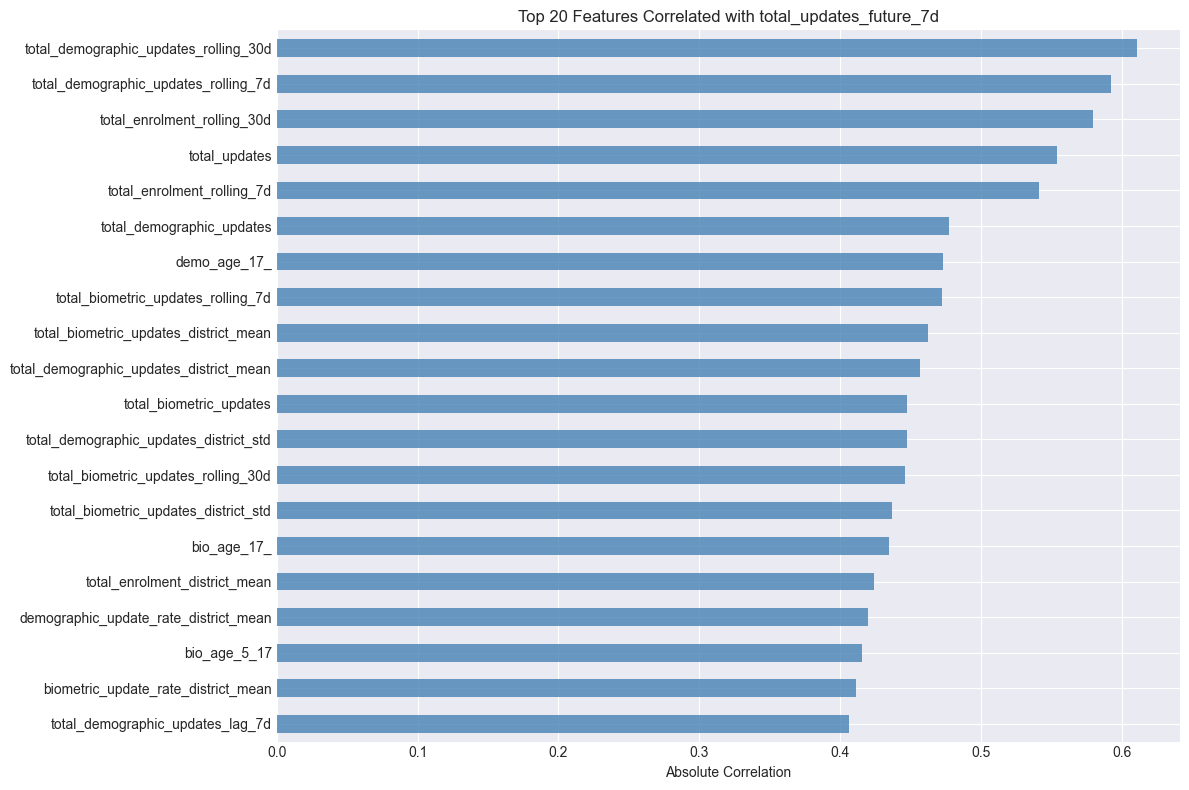

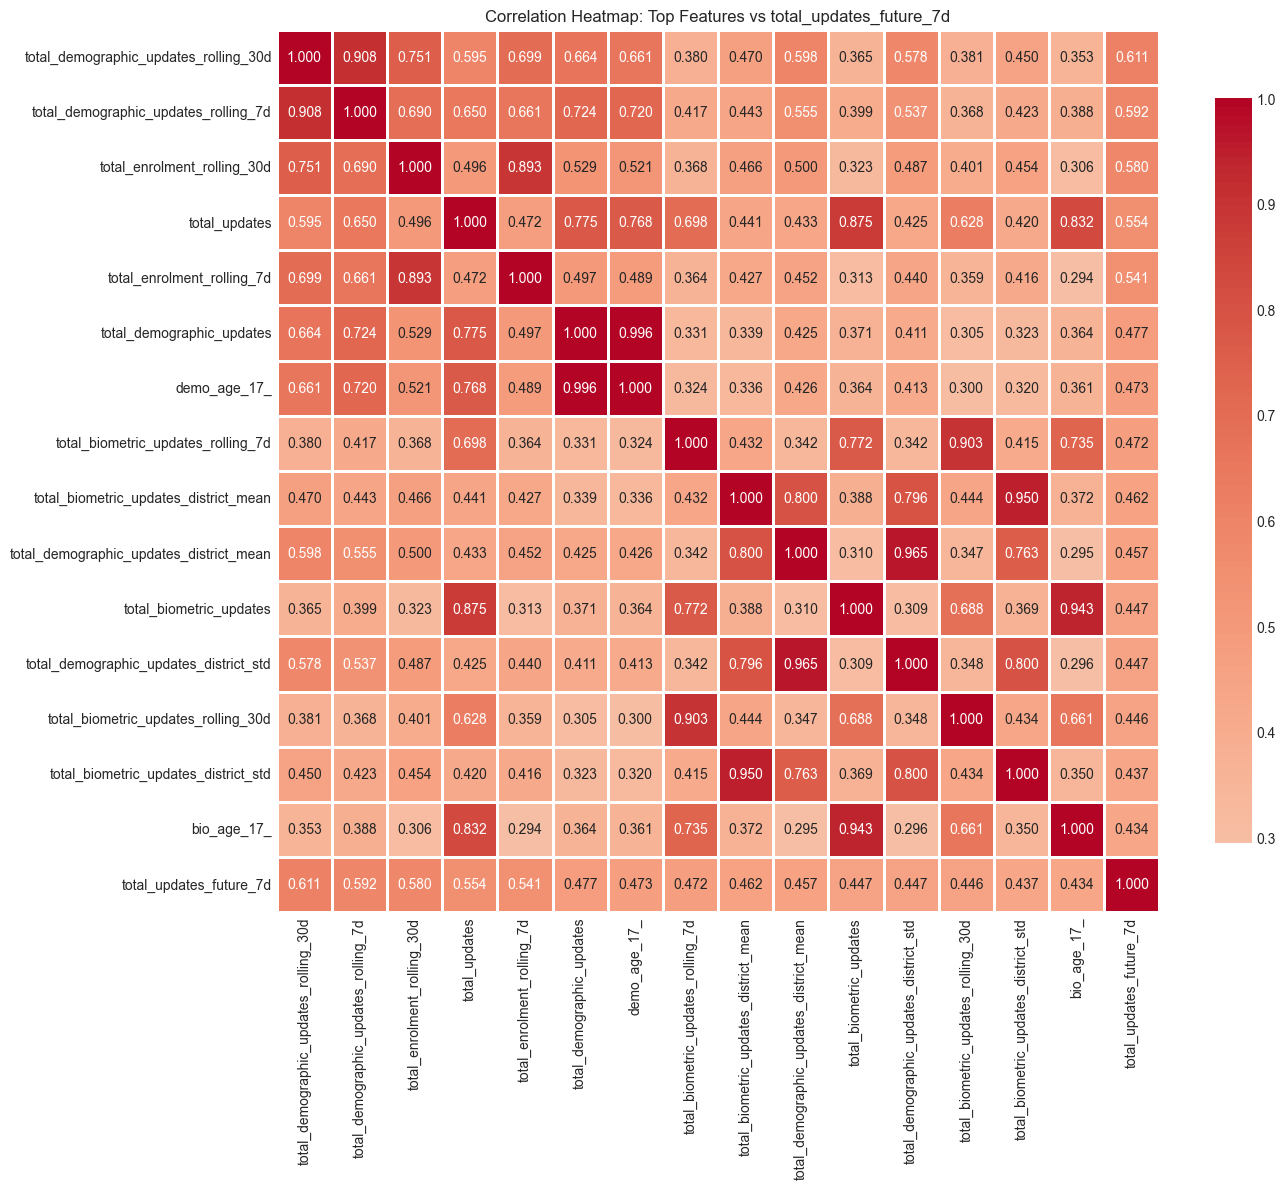


✓ Correlation analysis complete!


In [14]:
print("=" * 80)
print("FEATURE CORRELATION ANALYSIS")
print("=" * 80)

# Select numerical features for correlation analysis
numeric_features = df_features.select_dtypes(include=[np.number]).columns.tolist()

# Remove date-related and target features for correlation with targets
base_features = [col for col in numeric_features if not any(x in col for x in ['future_', 'cumsum_'])]
main_target = 'total_updates_future_7d'

if main_target in df_features.columns:
    # Create correlation dataset (remove rows with missing targets)
    df_corr = df_features[df_features[main_target].notna()].copy()
    
    print(f"\nRows with valid target: {len(df_corr):,}")
    
    # Calculate correlations with main target
    correlations = df_corr[base_features + [main_target]].corr()[main_target].drop(main_target)
    correlations = correlations.abs().sort_values(ascending=False)
    
    # Top 20 most correlated features
    top_correlations = correlations.head(20)
    
    print(f"\nTop 20 features correlated with '{main_target}':")
    for idx, (feature, corr) in enumerate(top_correlations.items(), 1):
        print(f"  {idx:2d}. {feature:50s} : {corr:.4f}")
    
    # Visualization: Top correlations
    plt.figure(figsize=(12, 8))
    top_correlations.plot(kind='barh', color='steelblue', alpha=0.8)
    plt.xlabel('Absolute Correlation')
    plt.title(f'Top 20 Features Correlated with {main_target}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    # Heatmap of top features
    top_features = top_correlations.head(15).index.tolist()
    corr_matrix = df_corr[top_features + [main_target]].corr()
    
    plt.figure(figsize=(14, 12))
    sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
                center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title(f'Correlation Heatmap: Top Features vs {main_target}')
    plt.tight_layout()
    plt.show()
    
else:
    print(f"⚠ Target variable '{main_target}' not found")

print("\n✓ Correlation analysis complete!")

## 14. Preliminary Feature Importance Analysis

Use Random Forest to assess feature importance.

PRELIMINARY FEATURE IMPORTANCE ANALYSIS

Training data shape: X=(2083061, 110), y=(2083061,)
Features: 110

Training Random Forest for feature importance...
  ✓ Model trained (R² score: 0.6858)

Top 20 Most Important Features:
  64. total_demographic_updates_rolling_30d              : 0.480107
  70. total_biometric_updates_rolling_7d                 : 0.158507
  47. days_since_start                                   : 0.091934
  34. day                                                : 0.069956
  57. total_updates                                      : 0.032413
  78. total_enrolment_rolling_30d                        : 0.032049
  71. total_biometric_updates_rolling_30d                : 0.027377
  48. total_biometric_updates                            : 0.015723
  39. month_cos                                          : 0.008807
   7. day_enrol                                          : 0.007774
  35. day_of_week                                        : 0.007447
  105. demographic_update

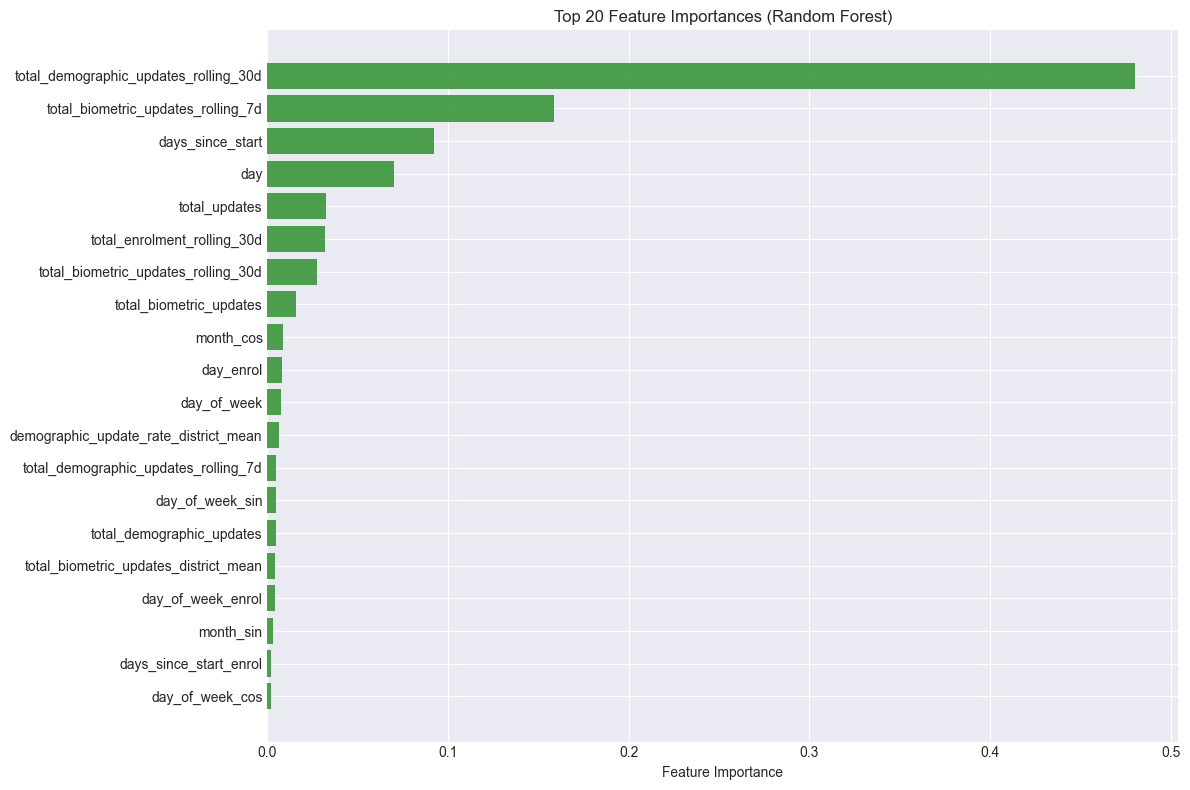


✓ 7 features account for 90% of importance

✓ Feature importance analysis complete!


In [15]:
print("=" * 80)
print("PRELIMINARY FEATURE IMPORTANCE ANALYSIS")
print("=" * 80)

main_target = 'total_updates_future_7d'

if main_target in df_features.columns:
    # Prepare data for modeling
    df_model = df_features[df_features[main_target].notna()].copy()
    
    # Select feature columns (exclude targets, dates, text)
    feature_cols = [col for col in df_model.columns if 
                    col not in ['date', 'state', 'district'] and
                    not any(x in col for x in ['future_', 'cumsum_', 'month_name', 'quarter_name'])]
    
    X = df_model[feature_cols]
    y = df_model[main_target]
    
    print(f"\nTraining data shape: X={X.shape}, y={y.shape}")
    print(f"Features: {len(feature_cols)}")
    
    # Train a simple Random Forest
    print("\nTraining Random Forest for feature importance...")
    rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
    rf.fit(X, y)
    
    print(f"  ✓ Model trained (R² score: {rf.score(X, y):.4f})")
    
    # Get feature importances
    importances = pd.DataFrame({
        'feature': feature_cols,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Top 20 important features
    top_importances = importances.head(20)
    
    print(f"\nTop 20 Most Important Features:")
    for idx, row in top_importances.iterrows():
        print(f"  {row.name+1:2d}. {row['feature']:50s} : {row['importance']:.6f}")
    
    # Visualization
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(top_importances)), top_importances['importance'], color='forestgreen', alpha=0.8)
    plt.yticks(range(len(top_importances)), top_importances['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 20 Feature Importances (Random Forest)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    # Cumulative importance
    importances['cumulative_importance'] = importances['importance'].cumsum()
    
    # Features accounting for 90% importance
    features_90 = importances[importances['cumulative_importance'] <= 0.90]
    print(f"\n✓ {len(features_90)} features account for 90% of importance")
    
else:
    print(f"⚠ Target variable '{main_target}' not found")

print("\n✓ Feature importance analysis complete!")

## 15. Save Feature Matrix

Save the complete feature matrix to CSV file.

In [16]:
print("=" * 80)
print("SAVING FEATURE MATRIX")
print("=" * 80)

# Save feature matrix
output_file = OUTPUT_PATH / 'feature_matrix.csv'

print(f"\nSaving to: {output_file}")
print(f"Shape: {df_features.shape}")

df_features.to_csv(output_file, index=False)

print(f"\n✓ Feature matrix saved successfully!")

# File info
file_size_mb = output_file.stat().st_size / (1024 * 1024)
print(f"File size: {file_size_mb:.2f} MB")

# Summary statistics
print("\n" + "=" * 80)
print("FEATURE MATRIX SUMMARY")
print("=" * 80)

print(f"\nTotal rows: {df_features.shape[0]:,}")
print(f"Total columns: {df_features.shape[1]:,}")

print(f"\nDate range: {df_features['date'].min()} to {df_features['date'].max()}")
print(f"Total days: {(df_features['date'].max() - df_features['date'].min()).days}")

print(f"\nGeographic coverage:")
print(f"  States: {df_features['state'].nunique()}")
print(f"  Districts: {df_features['district'].nunique()}")
print(f"  Pincodes: {df_features['pincode'].nunique()}")

print(f"\nFeature types:")
print(f"  Temporal features: {len([c for c in df_features.columns if any(x in c for x in ['year', 'month', 'day', 'week'])])}")
print(f"  Demographic features: {len([c for c in df_features.columns if 'ratio' in c or 'diversity' in c])}")
print(f"  Geographic features: {len([c for c in df_features.columns if 'encoded' in c or 'zone' in c])}")
print(f"  Update features: {len([c for c in df_features.columns if 'update' in c and 'future' not in c])}")
print(f"  Lag features: {len([c for c in df_features.columns if any(x in c for x in ['lag_', 'rolling_', 'growth_'])])}")
print(f"  Aggregated features: {len([c for c in df_features.columns if any(x in c for x in ['_mean', '_std', '_deviation'])])}")
print(f"  Target variables: {len([c for c in df_features.columns if 'future_' in c or 'cumsum_' in c])}")

# Memory usage
memory_mb = df_features.memory_usage(deep=True).sum() / (1024 * 1024)
print(f"\nMemory usage: {memory_mb:.2f} MB")

print("\n" + "=" * 80)
print("FEATURE ENGINEERING COMPLETE!")
print("=" * 80)
print("\n✅ All tasks completed successfully!")
print(f"\n📊 Feature matrix saved to: {output_file}")
print(f"\n🎯 Ready for modeling with {df_features.shape[1]:,} features!")

SAVING FEATURE MATRIX

Saving to: /home/prince/Desktop/UIDAI Hackathon/outputs/results/feature_matrix.csv
Shape: (2294731, 135)

✓ Feature matrix saved successfully!
File size: 2499.04 MB

FEATURE MATRIX SUMMARY

Total rows: 2,294,731
Total columns: 135

Date range: 2025-03-02 00:00:00 to 2025-12-29 00:00:00
Total days: 302

Geographic coverage:
  States: 60
  Districts: 1002
  Pincodes: 19815

Feature types:
  Temporal features: 28
  Demographic features: 6
  Geographic features: 3
  Update features: 53
  Lag features: 21
  Aggregated features: 30
  Target variables: 18

Memory usage: 2912.57 MB

FEATURE ENGINEERING COMPLETE!

✅ All tasks completed successfully!

📊 Feature matrix saved to: /home/prince/Desktop/UIDAI Hackathon/outputs/results/feature_matrix.csv

🎯 Ready for modeling with 135 features!


## 16. Feature Engineering Summary

### Features Created:

#### 1. Temporal Features (16 features):
- Basic: year, month, day, day_of_week, week_of_year, quarter
- Cyclical: month_sin, month_cos, day_of_week_sin, day_of_week_cos
- Boolean: is_weekend, is_month_start, is_month_end, is_quarter_start, is_quarter_end
- Trend: days_since_start

#### 2. Demographic Features:
- total_enrolment, child_ratio, adult_ratio, youth_ratio, infant_ratio
- age_diversity_index

#### 3. Update Features:
- total_demographic_updates, total_biometric_updates
- demographic_update_rate, biometric_update_rate, total_update_rate
- demographic_biometric_ratio

#### 4. Geographic Features:
- state_encoded, district_encoded
- pincode_zone, pincodes_in_district
- location_activity_level, population_density_proxy

#### 5. Lag Features (for each metric × 3 lags):
- Lag values: lag_7d, lag_14d, lag_30d
- Rolling averages: rolling_7d, rolling_30d
- Growth rates: growth_7d, growth_30d

#### 6. Aggregated Features (for each metric × 2 levels):
- State level: state_mean, state_std, state_deviation
- District level: district_mean, district_std, district_deviation

#### 7. Target Variables:
- future_7d, future_15d, future_30d (for demographic, biometric, total updates)
- cumsum_7d, cumsum_15d, cumsum_30d (cumulative future demand)

### Next Steps:
1. **Feature Selection**: Use correlation and importance analysis to select best features
2. **Model Training**: Train predictive models (Random Forest, XGBoost, LSTM)
3. **Hyperparameter Tuning**: Optimize model parameters
4. **Evaluation**: Assess model performance on test set
5. **Deployment**: Create prediction pipeline for real-time forecasting

### Key Insights:
- Features with highest importance are likely lag features and recent trends
- Geographic and temporal features provide context for seasonality
- Update rates capture regional behavior patterns
- Target variables enable multi-horizon forecasting (7, 15, 30 days)